# Basic example with triangular mesh
---
This notebook shows basic example of application of implicit filter on traingular mesh.

The example here creates a triangular mesh and synthetic data

In [13]:
import numpy as np
import math
# Mesh size
Lx = 1000
Ly = Lx
# Mesh resolution
dxm = 10
dym = dxm
cyclic = 0  # 1 if mesh is cyclic

### Create mesh

Making 2D regular array of points, their x and y coordinates. We will create triangles later

In [14]:
xx = np.arange(0, Lx + 1, dxm)
yy = np.arange(0, Ly + 1, dym)

nx = len(xx)
ny = len(yy)

nodnum = np.arange(0, nx * ny)
xcoord = np.zeros((ny, nx))
ycoord = xcoord.copy()

for i in range(nx):
    ycoord[i, :] = yy

for i in range(ny):
    xcoord[:, i] = xx

### Create synthetic data

In [15]:
tt = 50 * (np.random.random(xcoord.shape) - 0.5)
ttf = np.fft.fft2(tt)
# ============
# Make spectrum red
# ============
espectrum = np.zeros((nx // 2 + 1))  # Place for Fourier spectrum
kk = np.concatenate((np.arange(0, nx // 2 + 1), np.arange(-nx // 2 + 1, 0, 1)))  # Wavenumbers

for mx in range(nx):
    for my in range(ny):
        ll = np.sqrt(kk[my] * kk[my] + kk[mx] * kk[mx])  # Absolute value
        if my == 0 and mx == 0:  # Remove area mean
            ttf[my, mx] = 0.0
        else:  # Adjust amplitudes
            tmp = ttf[my, mx] / (np.power(ll, 1.5))  # 1.5 for -2 spectrum
            ttf[my, mx] = tmp
        if ll + 1 <= nx // 2 + 1:
            espectrum[np.floor(ll).astype(int)] += ttf[my, mx] * np.conj(ttf[my, mx])

espectrum = espectrum / np.power(nx, 4)

tt = np.real(np.fft.ifft2(ttf))  # We expect that it will show - 2 spectrum

/var/folders/p7/__mkfjf91fd70x4d4rzgvsq0rx9_k9/T/ipykernel_98183/2588423314.py:18: ComplexWarning: Casting complex values to real discards the imaginary part
  espectrum[np.floor(ll).astype(int)] += ttf[my, mx] * np.conj(ttf[my, mx])


### Reshape arrays and create triangulation

In [16]:
from implicit_filter import make_tri

nodnum = np.reshape(nodnum, [ny, nx]).T
xcoord = np.reshape(xcoord, [nx * ny])
ycoord = np.reshape(ycoord, [nx * ny])
tt = np.reshape(tt, [nx * ny])
tri = make_tri(nodnum, nx, ny) # Creates triangulation
n2d = len(xcoord)  # The number of vertices (nodes)
e2d = len(tri[:, 1]) # Number of elements (cells)

# Filtering

### Once the mesh and the data is ready filter can be prepared
It is important to note that filter object is mesh-specific, so it can be reused for all data based on this mesh.
However, any changes that were introduced to the mesh structure will cause undefined behaviour

In [17]:
from implicit_filter import TriangularFilter

In [18]:
tri_filter = TriangularFilter()
tri_filter.prepare(n2d=n2d, e2d=e2d, tri=tri, xcoord=xcoord, ycoord=ycoord)

### Once filter is prepared it can be used to filter any data

In [19]:
tts = tri_filter.compute(1, 2 * math.pi / 100., tt) # Scale corresponding to approx 100 km

### Before filtering

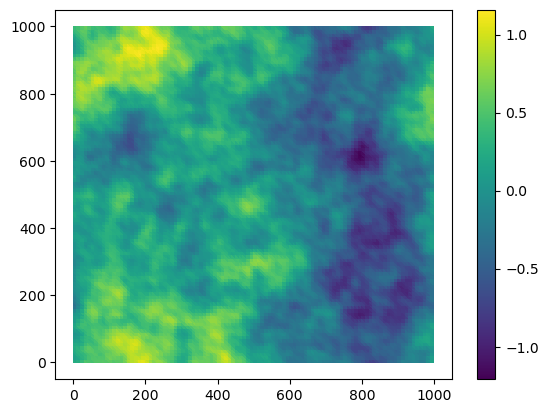

In [20]:
import matplotlib.pyplot as plt
import matplotlib as mpl

triangulation = mpl.tri.Triangulation(xcoord, ycoord, tri)

plt.tripcolor(triangulation, tt)
plt.colorbar()

### After filtering

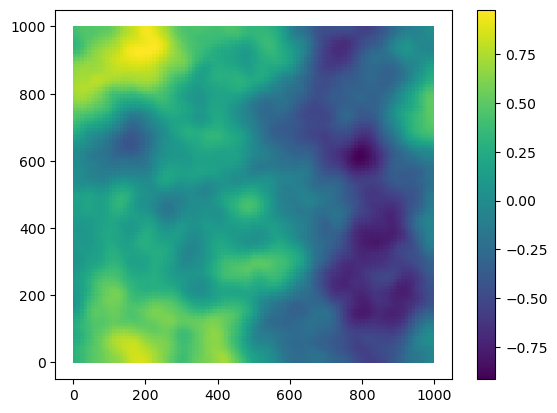

In [21]:
plt.tripcolor(triangulation, tts)
plt.colorbar()

### As one can see the result is low pass filtered. To get high pass version, one can simply subtract the filter output from the original data

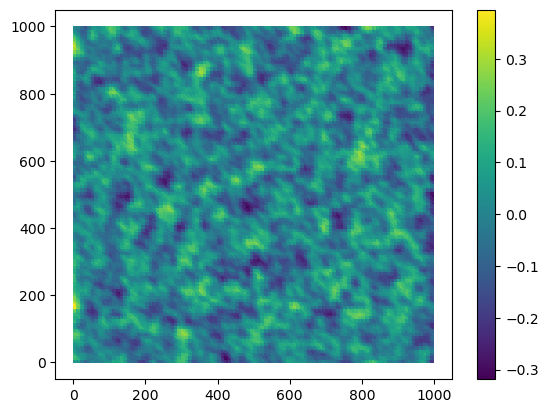

In [22]:
plt.tripcolor(triangulation, tts - tt)
plt.colorbar()

# Computing spectra

### To compute spectra one has to define wavelngths of interest.
Please not that the wavelengths should be comparable to the size and resolution of the mesh.
If the scales are reasonably small or large the filter will return defective results without a warning

In [23]:
kc = np.array([2, 4, 6, 8, 10, 12, 16, 20, 24, 30, 40, 60, 80, 100, 200]) * dxm
kc = 2 * math.pi / kc  # Wavenumbers

### Now one can use compute spectra method to get the spectra directly

In [24]:
spectra = tri_filter.compute_spectra_scalar(1, kc, tt)

### In this way a cumulative spectra is computed

Text(0, 0.5, '$ \\bar E $')

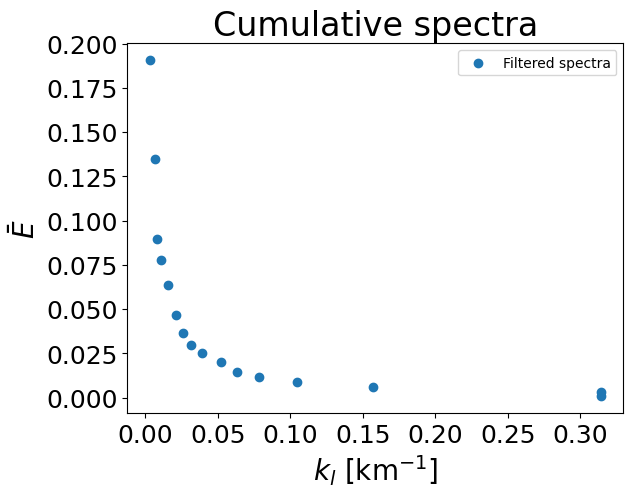

In [25]:
# Add the first element as spectra also contains value for unfiltered data on position 0
k = np.insert(kc, 0, kc[0])
plt.scatter(k, spectra, label="Filtered spectra")
plt.title("Cumulative spectra", fontsize=24)
plt.legend()
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"$k_l$ [km$^{-1}$]", fontsize=20)
plt.ylabel(r"$ \bar E $", fontsize=20)